# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 20, 11, 42, 1, 356844)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
with open('data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164438
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality__roll_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_roll_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='7.8115754E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
air_roll_fg = fs.get_feature_group(
    name='air_quality_roll',
    version=1,
)

arf = air_roll_fg.read().sort_values(by='date', ascending=True)
arf

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.40s) 


,date,pm25,pm25_3day_roll_mean,country,city,street,url
637,2020-11-10 00:00:00+00:00,5.030000,7.304875,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
315,2020-11-12 00:00:00+00:00,20.040001,7.304875,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
334,2020-11-13 00:00:00+00:00,20.299999,15.123333,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
1337,2020-11-14 00:00:00+00:00,21.990000,20.776667,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
1293,2020-11-15 00:00:00+00:00,19.230000,20.506666,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
...,...,...,...,...,...,...,...
1391,2024-11-16 00:00:00+00:00,4.090000,4.516667,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
1392,2024-11-17 00:00:00+00:00,5.090000,4.653334,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
1388,2024-11-18 00:00:00+00:00,6.630000,5.270000,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
1397,2024-11-19 00:00:00+00:00,35.000000,15.573333,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560


In [8]:
weather_fg_roll = fs.get_feature_group(
    name='weather_roll',
    version=1,
)
weather_fg_roll.read()
batch_data = weather_fg_roll.filter(weather_fg_roll.date >= today).read()
batch_data = batch_data.sort_values(by='date').reset_index(drop=True)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.61s) 


In [ ]:
import pandas as pd
import numpy as np

# Unione dei dati storici e meteo futuri
combined_data = pd.concat([arf[['date', 'pm25']], batch_data], ignore_index=True)

# Inizializza una colonna per i valori predetti di pm25
batch_data['predicted_pm25'] = np.nan
batch_data['pm25_3day_roll_mean'] = np.nan

# Iterazione giorno per giorno
for i in range(len(batch_data)):
    # Calcola la media rolling sui 3 giorni precedenti
    rolling_window = combined_data.loc[:len(arf) + i - 1, 'pm25'].rolling(window=3).mean()

    batch_data.loc[i, 'pm25_3day_roll_mean'] = rolling_window.iloc[-1]

    print("rolling",rolling_window.iloc[-1])
    
    # Crea le feature per la predizione
    features = batch_data.loc[i, [
        'pm25_3day_roll_mean',
        'temperature_2m_mean', 'precipitation_sum',
        'wind_speed_10m_max', 'wind_direction_10m_dominant'
    ]].values.reshape(1, -1)

  
    # Predici il valore di pm25
    prediction = retrieved_xgboost_model.predict(features)
    
    # Aggiorna i valori di `pm25` nel dataframe combinato e nel batch_data
    batch_data.loc[i, 'predicted_pm25'] = prediction[0]
    combined_data.loc[len(arf) + i, 'pm25'] = prediction[0]

# Ritorna il batch_data aggiornato
print("batch_data",batch_data)


0             NaN
1             NaN
2       15.123333
3       20.776667
4       20.506666
          ...    
1394     4.516667
1395     4.653334
1396     5.270000
1397    15.573333
1398    23.210000
Name: pm25, Length: 1399, dtype: float64
rolling 23.210000038146973
features [[23.210000038146973 5.05 0.0 4.8965297 143.97253]]
0             NaN
1             NaN
2       15.123333
3       20.776667
4       20.506666
          ...    
1395     4.653334
1396     5.270000
1397    15.573333
1398    23.210000
1399    28.459578
Name: pm25, Length: 1400, dtype: float64
rolling 28.459578196207683
features [[28.459578196207683 6.05 0.0 11.212135 317.6026]]
0             NaN
1             NaN
2       15.123333
3       20.776667
4       20.506666
          ...    
1396     5.270000
1397    15.573333
1398    23.210000
1399    28.459578
1400    22.309647
Name: pm25, Length: 1401, dtype: float64
rolling 22.30964724222819
features [[22.30964724222819 4.15 0.0 5.815978 158.19853]]
0             NaN
1    

In [ ]:
batch_data
import pandas as pd

# Assumendo che il tuo DataFrame si chiami df
# Riorganizza le colonne per mettere l'ultima colonna al primo posto
cols = batch_data.columns.tolist()
batch_data = batch_data[[cols[-1]] + cols[:-1]]  # Sposta l'ultima colonna in prima posizione

# Verifica la classe del DataFrame
print(type(batch_data))  # Deve restituire <class 'pandas.core.frame.DataFrame'>

# Visualizza il DataFrame riorganizzato
print(batch_data)

<class 'pandas.core.frame.DataFrame'>
   pm25_3day_roll_mean                      date  temperature_2m_mean  \
0            23.210000 2024-11-21 00:00:00+00:00                 5.05   
1            28.459578 2024-11-22 00:00:00+00:00                 6.05   
2            22.309647 2024-11-23 00:00:00+00:00                 4.15   
3            21.031306 2024-11-24 00:00:00+00:00                 4.75   
4            22.019704 2024-11-25 00:00:00+00:00                 6.05   
5            22.081134 2024-11-26 00:00:00+00:00                 8.00   
6            22.549720 2024-11-27 00:00:00+00:00                10.05   
7            20.054751 2024-11-28 00:00:00+00:00                 9.80   

   precipitation_sum  wind_speed_10m_max  wind_direction_10m_dominant   city  \
0                0.0            4.896530                   143.972534  serso   
1                0.0           11.212135                   317.602600  serso   
2                0.0            5.815978                   158.1

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [12]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['pm25_3day_roll_mean','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])

#['pm25_3day_roll_mean', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
batch_data


,pm25_3day_roll_mean,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,23.210000,2024-11-21 00:00:00+00:00,5.05,0.0,4.896530,143.972534,serso,22.378735
1,28.459578,2024-11-22 00:00:00+00:00,6.05,0.0,11.212135,317.602600,serso,16.550207
2,22.309647,2024-11-23 00:00:00+00:00,4.15,0.0,5.815978,158.198532,serso,24.164976
3,21.031306,2024-11-24 00:00:00+00:00,4.75,0.0,2.276840,161.564957,serso,25.343927
4,22.019704,2024-11-25 00:00:00+00:00,6.05,0.0,3.219938,153.435013,serso,16.734499
5,22.081134,2024-11-26 00:00:00+00:00,8.00,0.0,1.835647,191.309891,serso,25.570734
6,22.549720,2024-11-27 00:00:00+00:00,10.05,0.2,3.617955,174.289505,serso,17.859020
7,20.054751,2024-11-28 00:00:00+00:00,9.80,0.0,2.595997,146.309906,serso,19.278708


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   pm25_3day_roll_mean          8 non-null      float64            
 1   date                         8 non-null      datetime64[us, UTC]
 2   temperature_2m_mean          8 non-null      float32            
 3   precipitation_sum            8 non-null      float32            
 4   wind_speed_10m_max           8 non-null      float32            
 5   wind_direction_10m_dominant  8 non-null      float32            
 6   city                         8 non-null      object             
 7   predicted_pm25               8 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(1), object(1)
memory usage: 480.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [14]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,pm25_3day_roll_mean,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,23.210000,2024-11-21 00:00:00+00:00,5.05,0.0,4.896530,143.972534,serso,22.378735,Via dei Caduti,italy,1
1,28.459578,2024-11-22 00:00:00+00:00,6.05,0.0,11.212135,317.602600,serso,16.550207,Via dei Caduti,italy,2
2,22.309647,2024-11-23 00:00:00+00:00,4.15,0.0,5.815978,158.198532,serso,24.164976,Via dei Caduti,italy,3
3,21.031306,2024-11-24 00:00:00+00:00,4.75,0.0,2.276840,161.564957,serso,25.343927,Via dei Caduti,italy,4
4,22.019704,2024-11-25 00:00:00+00:00,6.05,0.0,3.219938,153.435013,serso,16.734499,Via dei Caduti,italy,5
5,22.081134,2024-11-26 00:00:00+00:00,8.00,0.0,1.835647,191.309891,serso,25.570734,Via dei Caduti,italy,6
6,22.549720,2024-11-27 00:00:00+00:00,10.05,0.2,3.617955,174.289505,serso,17.859020,Via dei Caduti,italy,7
7,20.054751,2024-11-28 00:00:00+00:00,9.80,0.0,2.595997,146.309906,serso,19.278708,Via dei Caduti,italy,8


In [15]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   pm25_3day_roll_mean          8 non-null      float64            
 1   date                         8 non-null      datetime64[us, UTC]
 2   temperature_2m_mean          8 non-null      float32            
 3   precipitation_sum            8 non-null      float32            
 4   wind_speed_10m_max           8 non-null      float32            
 5   wind_direction_10m_dominant  8 non-null      float32            
 6   city                         8 non-null      object             
 7   predicted_pm25               8 non-null      float32            
 8   street                       8 non-null      object             
 9   country                      8 non-null      object             
 10  days_before_forecast_day     8 non-null      int64    

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

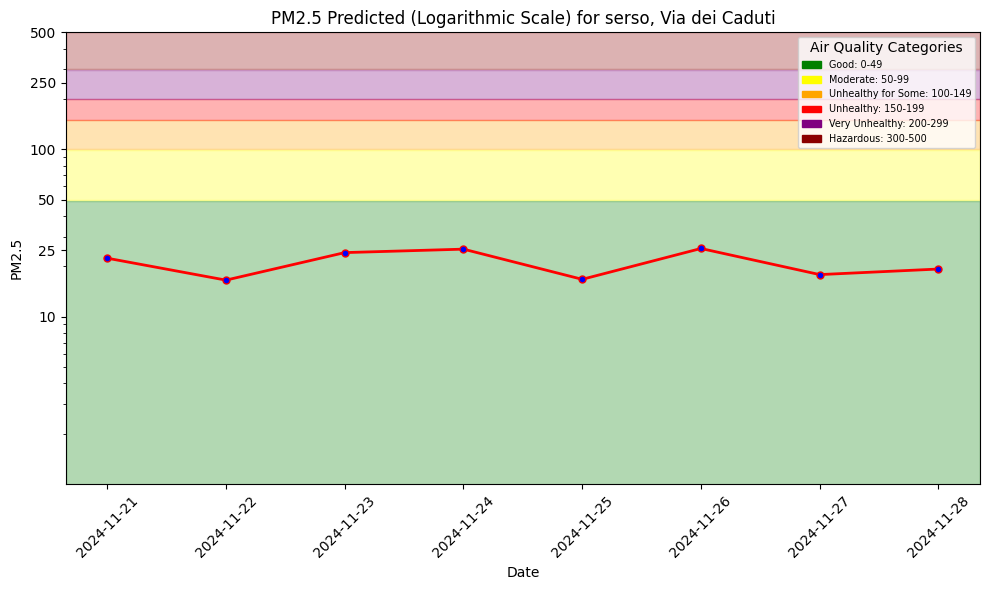

In [16]:
file_path = "../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [17]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_roll',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [18]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_roll_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1164438/jobs/named/aq_predictions_roll_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x27890be0400>, None)

In [19]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 


,pm25_3day_roll_mean,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,15.573334,2024-11-20 00:00:00+00:00,11.65,0.0,5.116561,309.289368,serso,11.957766,Via dei Caduti,italy,1
1,15.573334,2024-11-24 00:00:00+00:00,5.35,0.0,1.800000,180.000000,serso,12.094102,Via dei Caduti,italy,1
2,23.210000,2024-11-21 00:00:00+00:00,5.05,0.0,4.896530,143.972534,serso,22.378735,Via dei Caduti,italy,1


In [20]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_roll',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 


,date,pm25,pm25_3day_roll_mean,country,city,street,url
0,2021-05-31 00:00:00+00:00,2.06,1.986667,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
1,2022-09-06 00:00:00+00:00,6.72,4.896667,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
2,2023-06-17 00:00:00+00:00,5.07,4.123333,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
3,2022-01-08 00:00:00+00:00,8.49,5.290000,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
4,2021-04-06 00:00:00+00:00,0.85,2.120000,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
...,...,...,...,...,...,...,...
1394,2024-11-13 00:00:00+00:00,4.88,4.636667,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
1395,2024-11-12 00:00:00+00:00,4.30,4.293333,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
1396,2024-11-08 00:00:00+00:00,4.83,3.666667,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560
1397,2024-11-19 00:00:00+00:00,35.00,15.573333,italy,serso,Via dei Caduti,https://api.waqi.info/feed/A179560


In [21]:
print(retrieved_xgboost_model.feature_names_in_)
print(monitoring_df.columns)  # Controlla le colonne disponibili



['pm25_3day_roll_mean' 'temperature_2m_mean' 'precipitation_sum'
 'wind_speed_10m_max' 'wind_direction_10m_dominant']
Index(['pm25_3day_roll_mean', 'date', 'temperature_2m_mean',
       'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant', 'city', 'predicted_pm25', 'street',
       'country', 'days_before_forecast_day'],
      dtype='object')


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]
#print(outcome_df, preds_df)

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
#print(hindcast_df)
# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
   hindcast_df = util.backfill_predictions_for_monitoring(weather_fg_roll, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

                          date   pm25
0    2021-05-31 00:00:00+00:00   2.06
1    2022-09-06 00:00:00+00:00   6.72
2    2023-06-17 00:00:00+00:00   5.07
3    2022-01-08 00:00:00+00:00   8.49
4    2021-04-06 00:00:00+00:00   0.85
...                        ...    ...
1394 2024-11-13 00:00:00+00:00   4.88
1395 2024-11-12 00:00:00+00:00   4.30
1396 2024-11-08 00:00:00+00:00   4.83
1397 2024-11-19 00:00:00+00:00  35.00
1398 2024-11-20 00:00:00+00:00  28.00

[1399 rows x 2 columns]                        date  predicted_pm25
0 2024-11-20 00:00:00+00:00       11.957766
1 2024-11-24 00:00:00+00:00       12.094102
2 2024-11-21 00:00:00+00:00       22.378735
                       date  predicted_pm25  pm25
0 2024-11-20 00:00:00+00:00       11.957766  28.0


,date,predicted_pm25,pm25
0,2024-11-20 00:00:00+00:00,11.957766,28.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

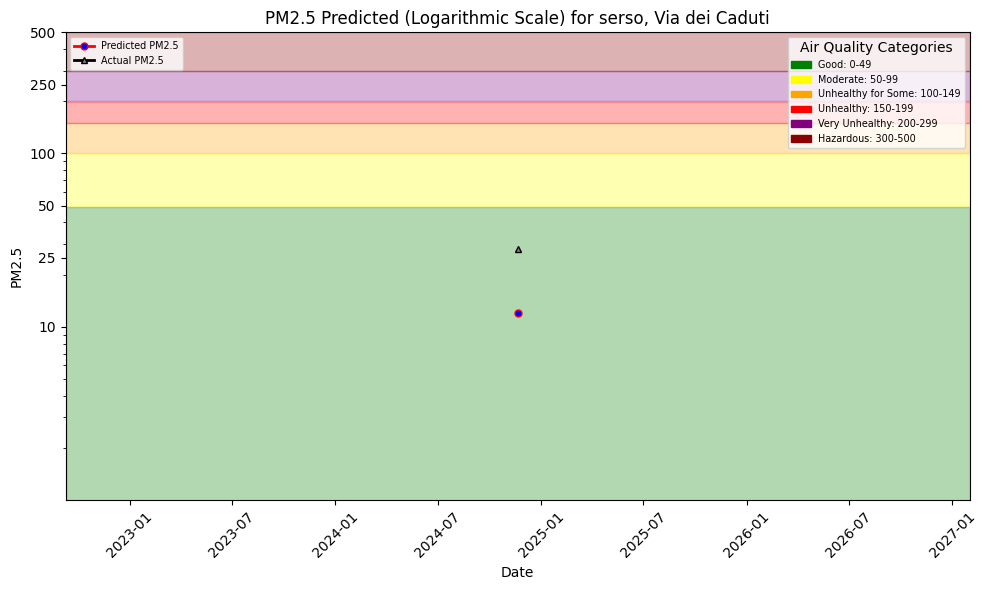

In [25]:
file_path = "../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---